# Geometric and topological analysis of all meshes

In [1]:
from collections import defaultdict
import os
from pathlib import Path

from dotenv import load_dotenv
import igl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from scipy.stats import ks_2samp, levene, mannwhitneyu
import trimesh
from tqdm.auto import tqdm

load_dotenv()
tqdm.pandas()

In [2]:
REPO_DIR = Path.cwd().parent
DATA_DIR = Path(os.environ.get("DATA_DIR", str(REPO_DIR / "data")))
FRAGMENT_DATA_DIR = DATA_DIR / "fragments"
SCROLL_DATA_DIR = DATA_DIR / "scrolls"

## Load data

We first need to load the scroll and fragment meshes. After that, a basic exploratory data analysis is done. Make sure you have downloaded the scroll and fragment `.obj` files.

### Read file paths and metadata

The first step is to create a data structure to hold the mesh file paths and other metadata.

#### Load scroll metadata

The `SCROLL_DATA_DIR` is expected to be of the form:
```
path/to/scroll/data
│
└───1
│   │
│   └───<segment id>
│       └───<segment id>.obj
│
└───2
    │
    └───<segment id>
        └───<segment id>.obj
```

In [3]:
scroll_data = defaultdict(list)
for scroll_path in tqdm(list(SCROLL_DATA_DIR.glob("*"))):
    scroll_id = scroll_path.name
    for segment_path in tqdm(list(scroll_path.glob("*"))):
        segment_id = segment_path.name
        obj_file = segment_path / f"{segment_id}.obj"
        if obj_file.is_file():
            scroll_data["obj_file_path"].append(obj_file)
            scroll_data["segment_id"].append(segment_id)
            scroll_data["scroll_id"].append(scroll_id)
        else:
            print(f"obj file missing: {obj_file}")

print(len(scroll_data["obj_file_path"]))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

232


If there are some missing scroll meshes, they are ignored for this analysis.

#### Load fragment metadata

The `FRAGMENT_DATA_DIR` is expected to be of the form:

```
path/to/fragment/data
│
├───1
│   └───result.obj
├───2
│   └───result.obj
└───3
    └───result.obj
```

In [4]:
frag_data = defaultdict(list)
for path in tqdm(list(FRAGMENT_DATA_DIR.glob("*"))):
    fragment_id = path.name
    for segment_path in tqdm(list(path.glob("*"))):
        if segment_path.suffix == ".obj":
            obj_file = segment_path
            if obj_file.is_file():
                frag_data["obj_file_path"].append(obj_file)
                frag_data["fragment_id"].append(fragment_id)
            else:
                print(f"obj file missing: {obj_file}")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Load meshes

We can now load the scroll and fragment meshes using the [trimesh](https://trimsh.org/) package.

In [5]:
for data in tqdm([scroll_data, frag_data], desc='Processing scroll and fragment meshes...'):
    for obj_path in tqdm(data["obj_file_path"], desc="Loading meshes..."):
        mesh = trimesh.load_mesh(obj_path)
        if mesh.is_empty:
            raise ValueError(f"Mesh {mesh} is empty")
        data["mesh"].append(mesh)

Processing scroll and fragment meshes...:   0%|          | 0/2 [00:00<?, ?it/s]

Loading meshes...:   0%|          | 0/232 [00:00<?, ?it/s]

Loading meshes...:   0%|          | 0/3 [00:00<?, ?it/s]

### Aggregrate scroll and fragment data

Here, we'll combine the scroll and fragment mesh data into a single data frame.

In [6]:
df_scroll = pd.DataFrame.from_dict(scroll_data)
df_scroll

obj_file_path      segment_id  \
0    D:\mesh-data\scrolls\1\20230504223647\20230504...  20230504223647   
1    D:\mesh-data\scrolls\1\20230504093154\20230504...  20230504093154   
2    D:\mesh-data\scrolls\1\20230504231922\20230504...  20230504231922   
3    D:\mesh-data\scrolls\1\20230504225948\20230504...  20230504225948   
4    D:\mesh-data\scrolls\1\20230504125349\20230504...  20230504125349   
..                                                 ...             ...   
227  D:\mesh-data\scrolls\2\20230517214715\20230517...  20230517214715   
228  D:\mesh-data\scrolls\2\20230519033308\20230519...  20230519033308   
229  D:\mesh-data\scrolls\2\20230520080703\20230520...  20230520080703   
230  D:\mesh-data\scrolls\2\20230522172834\20230522...  20230522172834   
231  D:\mesh-data\scrolls\2\20230522182853\20230522...  20230522182853   

    scroll_id                                               mesh  
0           1  <trimesh.Trimesh(vertices.shape=(223, 3), face...  
1           1  <trimesh.Trimesh(vertices.shape=(20026, 3), fa...  
2           1  <trimesh.Trimesh(vertices.shape=(6308, 3), fac...  
3           1  <trimesh.Trimesh(vertices.shape=(1956, 3), fac...  
4           1  <trimesh.Trimesh(vertices.shape=(1405, 3), fac...  
..        ...                                                ...  
227         2  <trimesh.Trimesh(vertices.shape=(4666, 3), fac...  
228         2  <trimesh.Trimesh(vertices.shape=(1405, 3), fac...  
229         2  <trimesh.Trimesh(vertices.shape=(3736, 3), fac...  
230         2  <trimesh.Trimesh(vertices.shape=(793, 3), face...  
231         2  <trimesh.Trimesh(vertices.shape=(19927, 3), fa...  

[232 rows x 4 columns]

In [7]:
df_frag = pd.DataFrame.from_dict(frag_data)
df_frag

obj_file_path fragment_id  \
0  D:\mesh-data\fragments\1\result.obj           1   
1  D:\mesh-data\fragments\2\result.obj           2   
2  D:\mesh-data\fragments\3\result.obj           3   

                                                mesh  
0  <trimesh.Trimesh(vertices.shape=(40763, 3), fa...  
1  <trimesh.Trimesh(vertices.shape=(34531, 3), fa...  
2  <trimesh.Trimesh(vertices.shape=(42276, 3), fa...

Let's also create a volume type and volume ID to associate with each volumetric segment.

In [8]:
df_scroll["volume_type"] = "scroll"
df_scroll["volume_id"] = df_scroll.segment_id + "-" + df_scroll.scroll_id
df_frag["volume_type"] = "fragment"
df_frag["volume_id"] = df_frag.fragment_id

In [9]:
df = pd.concat((df_scroll, df_frag)).reset_index()
df["volume_type"] = df["volume_type"].astype("category")
df

index                                      obj_file_path      segment_id  \
0        0  D:\mesh-data\scrolls\1\20230504223647\20230504...  20230504223647   
1        1  D:\mesh-data\scrolls\1\20230504093154\20230504...  20230504093154   
2        2  D:\mesh-data\scrolls\1\20230504231922\20230504...  20230504231922   
3        3  D:\mesh-data\scrolls\1\20230504225948\20230504...  20230504225948   
4        4  D:\mesh-data\scrolls\1\20230504125349\20230504...  20230504125349   
..     ...                                                ...             ...   
230    230  D:\mesh-data\scrolls\2\20230522172834\20230522...  20230522172834   
231    231  D:\mesh-data\scrolls\2\20230522182853\20230522...  20230522182853   
232      0                D:\mesh-data\fragments\1\result.obj             NaN   
233      1                D:\mesh-data\fragments\2\result.obj             NaN   
234      2                D:\mesh-data\fragments\3\result.obj             NaN   

    scroll_id                                               mesh volume_type  \
0           1  <trimesh.Trimesh(vertices.shape=(223, 3), face...      scroll   
1           1  <trimesh.Trimesh(vertices.shape=(20026, 3), fa...      scroll   
2           1  <trimesh.Trimesh(vertices.shape=(6308, 3), fac...      scroll   
3           1  <trimesh.Trimesh(vertices.shape=(1956, 3), fac...      scroll   
4           1  <trimesh.Trimesh(vertices.shape=(1405, 3), fac...      scroll   
..        ...                                                ...         ...   
230         2  <trimesh.Trimesh(vertices.shape=(793, 3), face...      scroll   
231         2  <trimesh.Trimesh(vertices.shape=(19927, 3), fa...      scroll   
232       NaN  <trimesh.Trimesh(vertices.shape=(40763, 3), fa...    fragment   
233       NaN  <trimesh.Trimesh(vertices.shape=(34531, 3), fa...    fragment   
234       NaN  <trimesh.Trimesh(vertices.shape=(42276, 3), fa...    fragment   

            volume_id fragment_id  
0    20230504223647-1         NaN  
1    20230504093154-1         NaN  
2    20230504231922-1         NaN  
3    20230504225948-1         NaN  
4    20230504125349-1         NaN  
..                ...         ...  
230  20230522172834-2         NaN  
231  20230522182853-2         NaN  
232                 1           1  
233                 2           2  
234                 3           3  

[235 rows x 8 columns]

## Mesh exploratory data analysis

Now that we have loaded the meshes, let's take a look at some basic geometric and topological features.

### Compute mesh statistics

First, let's compute some mesh statistics for all volumetric segments.

In [10]:
df["integral_mean_curvature"] = df["mesh"].progress_apply(lambda m: m.integral_mean_curvature)
df["euler_number"] = df["mesh"].progress_apply(lambda m: m.euler_number)
df["area"] = df["mesh"].progress_apply(lambda m: m.area)
df["num_vertices"] = df["mesh"].apply(lambda m: m.vertices.shape[0])
df["num_edges"] = df["mesh"].apply(lambda m: m.edges.shape[0])
df["num_faces"] = df["mesh"].apply(lambda m: m.faces.shape[0])

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

### Basic mesh analysis

We can now give a basic overview of the geometry and topology of these segments.

#### Geometric analysis

Let's first analyze the geometry of these meshes. We must take into account where the triangles on the mesh are in 3D space.

Here, we show a histogram of the mesh area. The surface area for a given mesh is in units of $L^2$, where $L$ is the unit of length for each mesh.

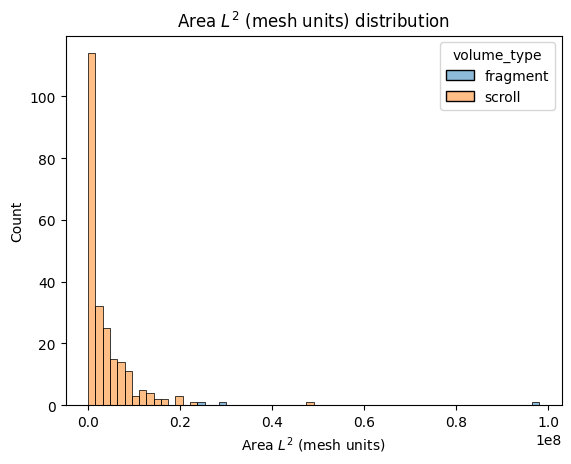

In [11]:
plt.title("Area $L^2$ (mesh units) distribution")
sns.histplot(data=df, x='area', hue='volume_type')
plt.xlabel("Area $L^2$ (mesh units)")
plt.show()

Here we look at the distribution of the surface integral of the mean curvature, which can roughly be interpreted as a measure of how much the surface bends on average over its entire extent.

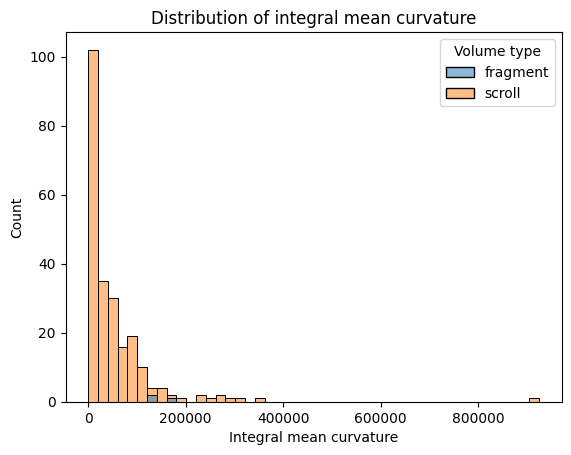

In [12]:
plt.title("Distribution of integral mean curvature")
g = sns.histplot(data=df, x='integral_mean_curvature', hue='volume_type')
g.legend_.set_title("Volume type")
plt.xlabel("Integral mean curvature")
plt.show()

Bear in mind that the integral mean curvature also depends on the mesh unit $L$.

Now let's look at face area. We can calculate the area of a single face using the cross product of two edges as illustrated below:

<img src="https://dctqed2pc42y2.cloudfront.net/overleaf-assets/images/trekantareal.svg" width=300 height=300/>

In particular, we will show the descriptive statistics of the face area along with a measure `face_area_sigma`, which normalizes the face area by the mean area. For example, a face area sigma of $5.33$ means that the biggest face is ~$5$ times larger than the average face. An ideal isotropic mesh would have both minimum and maximum area close to $1$.

A higher sigma value indicates more variability in face areas, which may be indicative of a mesh that has a mix of small and large faces. On the other hand, a smaller sigma value would suggest that the face areas are relatively uniform. It also can tell us a bit about meshing quality. See below for an example of low and high isotropy and differing face area sigma values.

![Isotropy example](https://github.com/lschlessinger1/vesuvius-topogeo/blob/main/images/isotropy-example.png?raw=true "Comparison of isotropic and anisotropic meshes.")

image credit: 

> https://github.com/BrunoLevy/geogram/wiki/tutorials/Remeshing.png

In [13]:
# Compute areas, min, max, and standard deviation
df["face_area"] = df["mesh"].progress_apply(lambda m: igl.doublearea(m.vertices, m.faces) / 2.)
df["face_area_mean"] = df["face_area"].apply(np.nanmean)
df["face_area_min"] = df["face_area"].apply(np.nanmin)
df["face_area_max"] = df["face_area"].apply(np.nanmax)
df["face_area_ns"] = df["face_area"] - df["face_area_mean"]
df["face_area_sigma"] = ((df["face_area_ns"] ** 2).apply(np.nanmean)) ** 0.5
df[["face_area_mean", "face_area_min", "face_area_max", "face_area_sigma"]].describe()

  0%|          | 0/235 [00:00<?, ?it/s]

face_area_mean  face_area_min  face_area_max  face_area_sigma
count      235.000000     235.000000     235.000000       235.000000
mean       153.620291      34.848066     469.679417        28.775825
std         86.988196      29.687443     427.833885        43.585557
min         44.497356       0.000000      75.306922        10.090667
25%        142.247341       9.140787     247.123637        19.440058
50%        153.107526      27.712014     313.980219        22.115754
75%        154.985029      56.875662     511.646427        25.242627
max       1435.157257     111.399077    3813.344144       634.672528

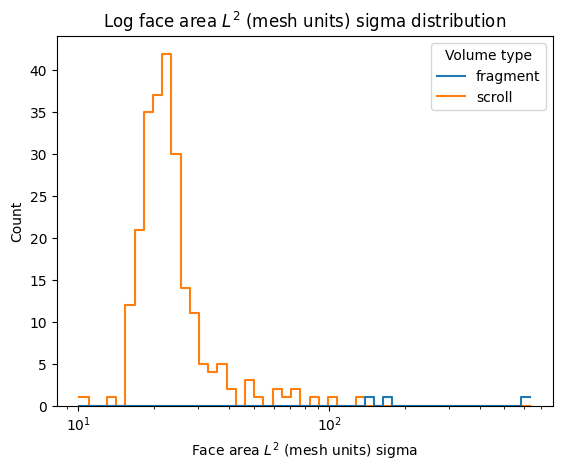

In [14]:
plt.title("Log face area $L^2$ (mesh units) sigma distribution")
g = sns.histplot(data=df, x='face_area_sigma', hue='volume_type', fill=False, element="step", log_scale=True)
g.legend_.set_title("Volume type")
plt.xlabel("Face area $L^2$ (mesh units) sigma")
plt.show()

Note the significant differences between the scrolls and fragments. Also be aware that the face area is in mesh units for each respective domain, which is possibly the cause for the difference.

Now onto internal angles. A "good" triangle mesh typically is equilateral. First, we look at descriptive statistics and also compute the `internal_angles_sigma`, which normalizes by mean internal angles. Face angles should be close to 60 degrees (90 for quads) in a perfectly regular triangulation.

A low value for `internal_angles_sigma` would imply that the internal angles of faces within a mesh are relatively uniform or similar to each other. This could mean that the mesh is regular or that its faces are quite similar in shape. A high value, on the other hand, would indicate a large variability in the internal angles among the faces. This could point to a mesh that has a variety of face shapes, which might be an indicator of complex geometry or non-uniform tessellation.

![Internal angle example](https://github.com/lschlessinger1/vesuvius-topogeo/blob/main/images/slide_018.jpg?raw=true "What makes a good triangle mesh?")

image credit: http://15462.courses.cs.cmu.edu/fall2020content/lectures/11_geometryprocessing/images/slide_018.jpg

In [15]:
# Compute per-face angles, min, max, and standard deviation
df["internal_angles"] = df["mesh"].progress_apply(lambda m: igl.internal_angles(m.vertices, m.faces))
df["internal_angles"] = 360.0 * (df["internal_angles"] / (2 * np.pi))
df["internal_angles_mean"] = df["internal_angles"].apply(np.nanmean)
df["internal_angles_min"] = df["internal_angles"].apply(np.nanmin)
df["internal_angles_max"] = df["internal_angles"].apply(np.nanmax)
df["internal_angles_ns"] = df["internal_angles"] - df["internal_angles_mean"]
df["internal_angles_sigma"] = ((df["internal_angles_ns"] ** 2).apply(np.nanmean)) ** 0.5
df[["internal_angles_mean", "internal_angles_min", "internal_angles_max", "internal_angles_sigma"]].describe()

  0%|          | 0/235 [00:00<?, ?it/s]

internal_angles_mean  internal_angles_min  internal_angles_max  \
count            235.000000           235.000000           235.000000   
mean              59.999992            10.208904           155.966917   
std                0.000087            10.359213            24.217976   
min               59.998805             0.000000            98.923010   
25%               60.000000             1.398495           134.096551   
50%               60.000000             6.580828           165.620992   
75%               60.000000            17.976322           176.680117   
max               60.000000            35.206116           179.952158   

       internal_angles_sigma  
count             235.000000  
mean               14.781831  
std                 5.294489  
min                10.559631  
25%                12.524241  
50%                13.395100  
75%                14.550812  
max                47.544619

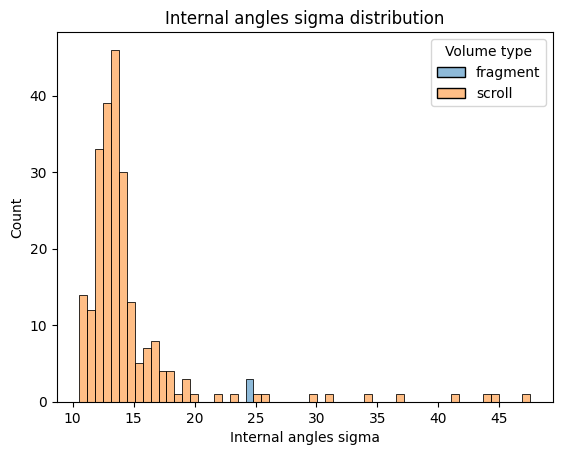

In [16]:
plt.title("Internal angles sigma distribution")
g = sns.histplot(data=df, x='internal_angles_sigma', hue='volume_type')
g.legend_.set_title("Volume type")
plt.xlabel("Internal angles sigma")
plt.show()

We can clearly see that clustering of the fragments around $25$. For purposes related to the finite element method, the closer the angles are to 60 degrees the more stable will the optimization be. Using many of these meshes will probably result in artifacts if used for solving partial differential equations.

#### Topological analysis

Let's now analyze the topology of these meshes. Here, we are interested in how the triangles are connected (ignoring the
positions entirely).

We first look at the Euler characteristic $\chi = V - E + F$ for each mesh. The Euler characteristic is a topological invariant that describes the mesh's shape or structure regardless of the way it is bent. Since these fragment and scroll meshes are topologically the same as disks, we expect them all to have $\chi = 1$.

In [17]:
df["euler_number"].unique()

array([1, 2], dtype=int64)

Let's look at the outlier having a non-unit Euler characteristic:

In [18]:
df.loc[df["euler_number"] != 1]

index                                      obj_file_path      segment_id  \
35     35  D:\mesh-data\scrolls\1\20230512112647\20230512...  20230512112647   

   scroll_id                                               mesh volume_type  \
35         1  <trimesh.Trimesh(vertices.shape=(5937, 3), fac...      scroll   

           volume_id fragment_id  integral_mean_curvature  euler_number  ...  \
35  20230512112647-1         NaN            121320.868064             2  ...   

    face_area_min  face_area_max  \
35       0.220018    1048.143109   

                                         face_area_ns  face_area_sigma  \
35  [-18.328555677109975, -16.298004408940812, 14....        62.943481   

                                      internal_angles  internal_angles_mean  \
35  [[47.57677173799375, 91.91213216109658, 40.511...                  60.0   

    internal_angles_min  internal_angles_max  \
35             0.057329           179.853184   

                                   internal_angles_ns  internal_angles_sigma  
35  [[-12.423228262006248, 31.91213216109658, -19....              41.623717  

[1 rows x 26 columns]

Let's look at this mesh. 

First, we have to define a helper function to visualize it.

In [19]:
def show_mesh_without_texture(mesh: trimesh.Trimesh, title: str = "Mesh", intensity=None, colorscale=None, **mesh_kwargs):
    vertices = mesh.vertices
    triangles = mesh.faces

    fig = go.Figure(
        data=[
            go.Mesh3d(
                x=vertices[:,0],
                y=vertices[:,1],
                z=vertices[:,2],
                i=triangles[:,0],
                j=triangles[:,1],
                k=triangles[:,2],
                opacity=0.5,
                intensity=intensity,
                colorscale=colorscale,
                **mesh_kwargs,
            )
        ],
    )

    fig.update_layout(
        title=dict(text=title)
    )

    fig.show()

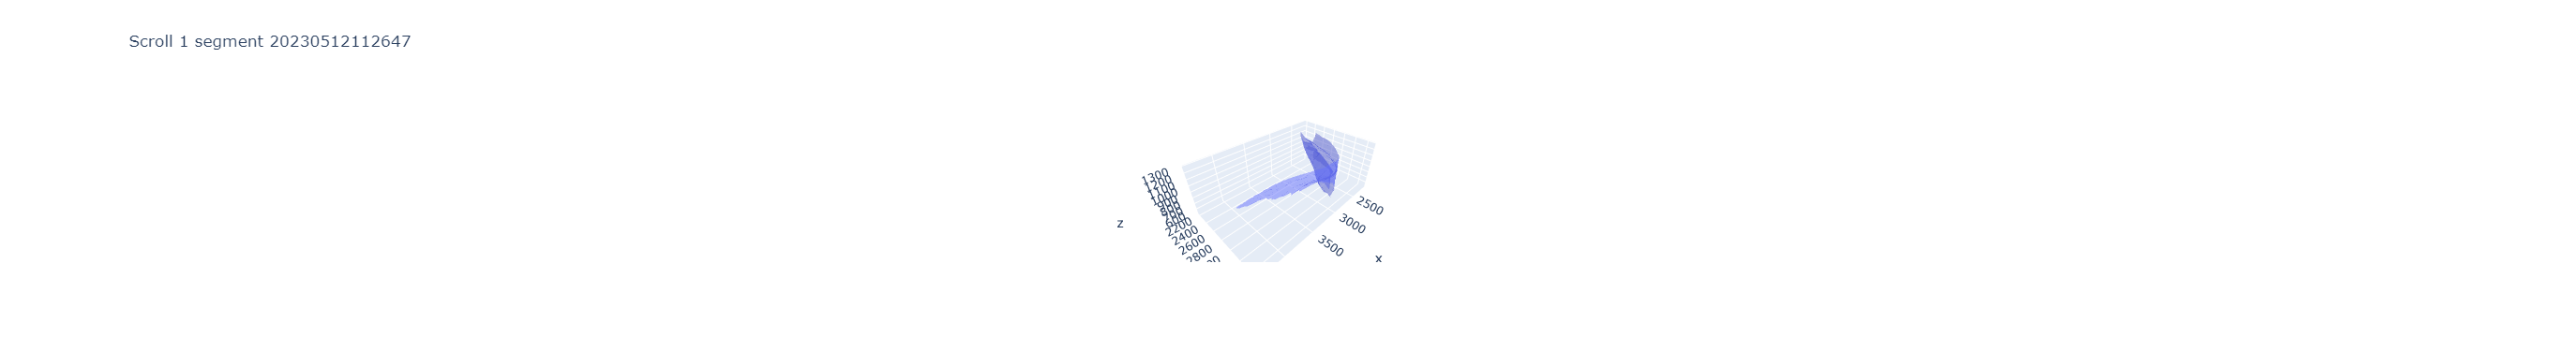

In [20]:
row = df.loc[df["euler_number"] != 1].iloc[0]
show_mesh_without_texture(row.mesh, title=f"Scroll {row.scroll_id} segment {row.segment_id}")

By visual inspection, it's not obvious why the topology of this particular is different from the others. The value $\chi=2$ implies that we could stretch it to be a sphere. Perhaps there is some overlap in the mesh.

Now we look at the vertex number distribution.

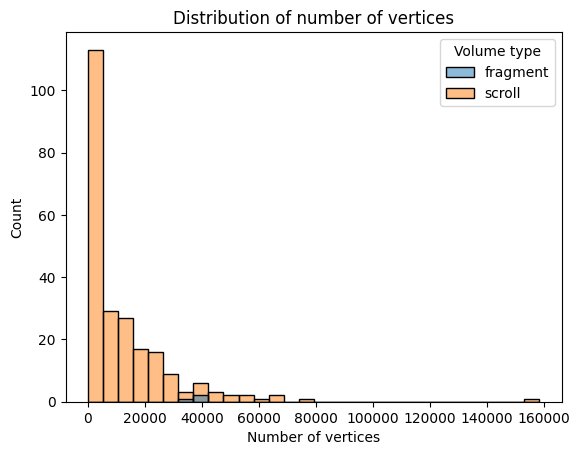

In [21]:
plt.title("Distribution of number of vertices")
g = sns.histplot(data=df, x='num_vertices', hue='volume_type')
g.legend_.set_title("Volume type")
plt.xlabel("Number of vertices")
plt.show()

Now we look at the edge number distribution.

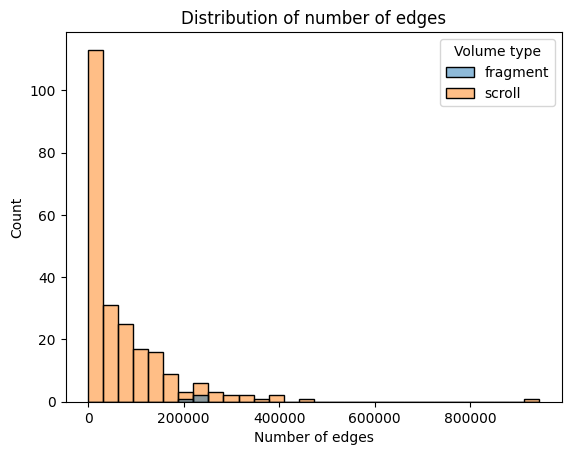

In [22]:
plt.title("Distribution of number of edges")
g = sns.histplot(data=df, x='num_edges', hue='volume_type')
g.legend_.set_title("Volume type")
plt.xlabel("Number of edges")
plt.show()

Now we look at the face number distribution.

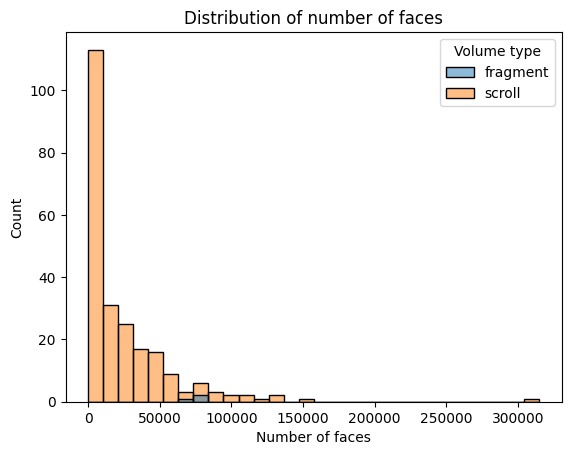

In [23]:
plt.title("Distribution of number of faces")
g = sns.histplot(data=df, x='num_faces', hue='volume_type')
g.legend_.set_title("Volume type")
plt.xlabel("Number of faces")
plt.show()

We'll investigate *irregular* vertices next. A vertex is irregular if it has more than $6$ incident edges on a triangle mesh ($4$ for quads). Vertices on the boundary are ignored. Irregular vertices are associated with the topology and geometry of a surface as well as mesh quality. Topologically, if a closed mesh surface has a non-zero Euler characteristic, at least one irregular vertex exists. Geometrically, they occur in areas with high discrete Gaussian curvature, their types influenced by the specific curvature values.

We are interested in particular in the ratio of regular to irregular vertices.

<img src="http://15462.courses.cs.cmu.edu/fall2020content/lectures/11_geometryprocessing/images/slide_019.jpg" height=500 width=500/>

In [24]:
# Count the number of irregular vertices, the border is ignored.
df["irregular_vertices"] = df["mesh"].progress_apply(lambda m: igl.is_irregular_vertex(m.vertices, m.faces))
df["irregular_vertices_count"] = df["irregular_vertices"].apply(sum)
df["irregular_vertices_ratio"] = df["irregular_vertices_count"] / df["num_vertices"]
df[["irregular_vertices_count", "irregular_vertices_ratio"]].describe()

  0%|          | 0/235 [00:00<?, ?it/s]

irregular_vertices_count  irregular_vertices_ratio
count                235.000000                235.000000
mean                5207.327660                  0.385836
std                 7339.673234                  0.063014
min                    0.000000                  0.000000
25%                  516.500000                  0.368710
50%                 2508.000000                  0.394244
75%                 7776.000000                  0.410556
max                66929.000000                  0.605805

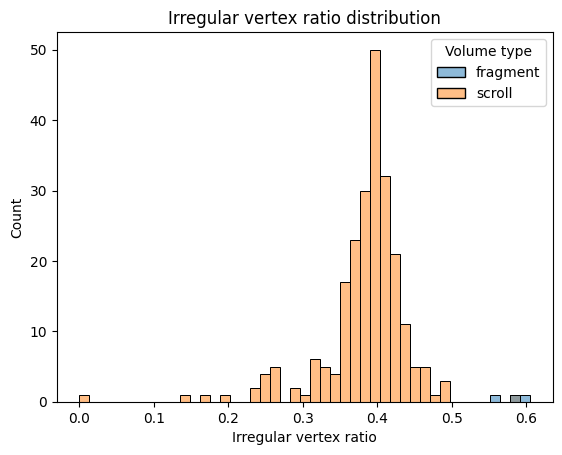

In [25]:
plt.title("Irregular vertex ratio distribution")
g = sns.histplot(data=df, x='irregular_vertices_ratio', hue='volume_type')
g.legend_.set_title("Volume type")
plt.xlabel("Irregular vertex ratio")
plt.show()

Note the significant difference between fragments ($\mu \approx 0.58$) and scrolls ($\mu \approx 0.38$). We can clearly see that fragments are on the higher end of that histogram. Purely by looking at this ratio, it seems like fragment meshes are more irregular. Interpretation of these results and understanding *why* we see this difference in domains is better suited for another analysis because it could be due to many factors such as differing mesh generation methods, mesh processing operations, geometries, or other factors.

## Curvature analysis

We can finally compare the curvatures of the scrolls and fragments. First, we look at curvature differences *within* scrolls and fragments and then move on to comparing *between* scrolls and fragments.

For this notebook, two representative curvature measures are chosen, namely the discrete internal Gaussian curvature and the discrete internal mean curvature. Only the curvature of the interior nodes is considered to be able to fairly compare meshes having different boundary lengths.

[This article](http://rodolphe-vaillant.fr/entry/33/curvature-of-a-triangle-mesh-definition-and-computation) has more information regarding Gaussian curvature ($K$) and mean curvature ($H$) on triangle meshes. There is also this helpful figure that illustrates the differences.

![Image of basic shapes defined by the signs of mean and Gaussian curvatures](https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs00429-011-0325-x/MediaObjects/429_2011_325_Fig2_HTML.gif?as=webp)

Image credit:

> Clouchoux, C., Kudelski, D., Gholipour, A., Warfield, S. K., Viseur, S., Bouyssi-Kobar, M., ... & Limperopoulos, C. (2012). Quantitative in vivo MRI measurement of cortical development in the fetus. Brain Structure and Function, 217, 127-139.

### Define utility functions

First, define some helper functions

In [26]:
def get_boundary_vertex_mask(v: np.ndarray, f: np.ndarray) -> np.ndarray:
    return np.array(igl.is_border_vertex(v, f))


def get_gaussian_curvature_internal(v: np.ndarray, f: np.ndarray, is_boundary_vertex=None) -> np.ndarray:
    if is_boundary_vertex is None:
        is_boundary_vertex =  get_boundary_vertex_mask(v, f)

    k_all = igl.gaussian_curvature(v, f)
    k_internal = k_all[~is_boundary_vertex]
    return k_internal


def compute_mean_curvature(v: np.ndarray, f: np.ndarray):
    _, _, k1, k2 = igl.principal_curvature(v, f)
    return 0.5 * (k1 + k2)
    

def get_mean_curvature_internal(v: np.ndarray, f: np.ndarray, is_boundary_vertex=None) -> np.ndarray:
    if is_boundary_vertex is None:
        is_boundary_vertex =  get_boundary_vertex_mask(v, f)

    h_all = compute_mean_curvature(v, f)
    h_internal = h_all[~is_boundary_vertex]
    
    return h_internal


def describe_array_statistics(group):
    arr_values = group.explode()
    return arr_values.astype(float).describe()

### Show curvatures on sample mesh

To help gain an understanding of the curvature values, let's show them on a sample mesh.

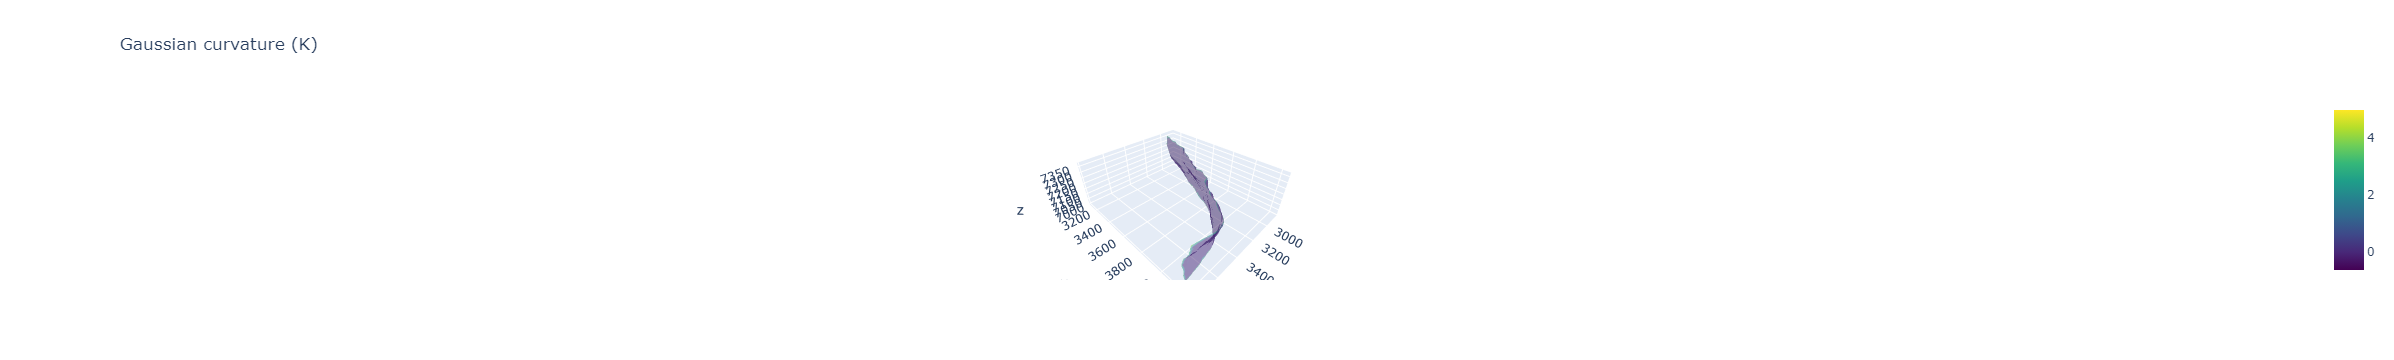

In [27]:
row = df.iloc[3]
k = igl.gaussian_curvature(row.mesh.vertices, row.mesh.faces)
show_mesh_without_texture(row.mesh, "Gaussian curvature (K)", colorscale="Viridis", intensity=k)

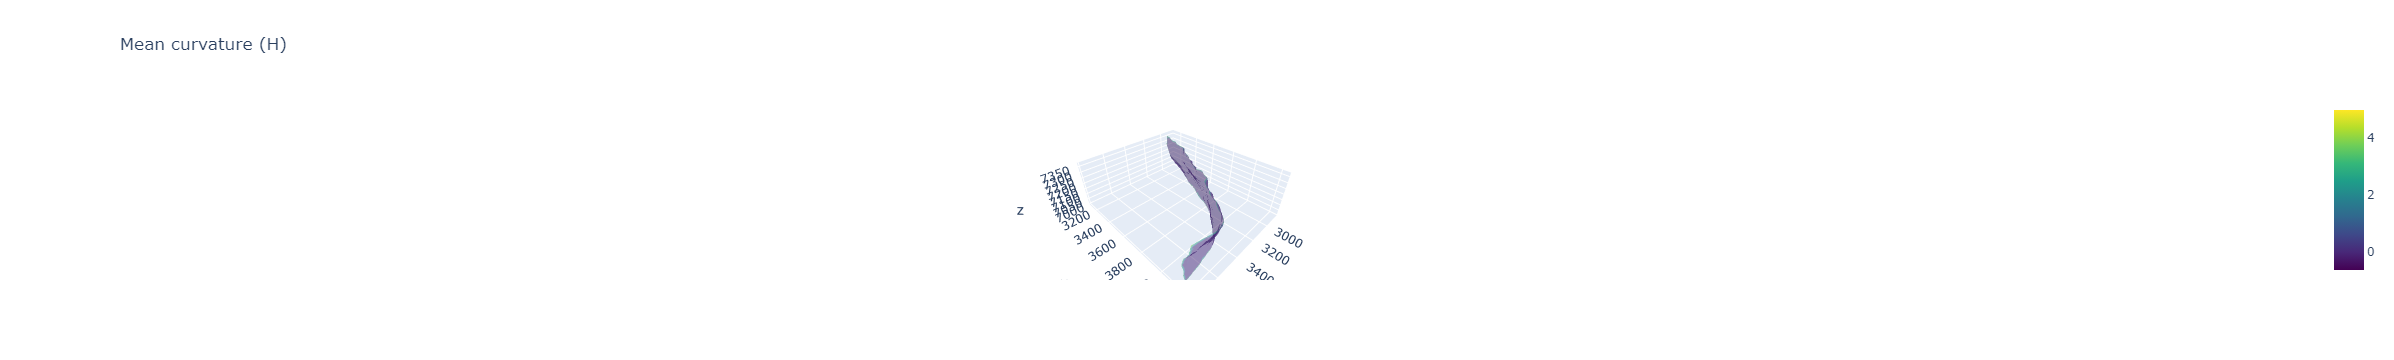

In [28]:
h = compute_mean_curvature(row.mesh.vertices, row.mesh.faces)
show_mesh_without_texture(row.mesh, "Mean curvature (H)", colorscale="Viridis", intensity=k)

As you can see, the high values of the curvature (green/yellow areas) is dominated by the boundary vertices. For purposes of visualization, let's try to mitigate that by taking this nonlinear transform:

$$
K_{\text{normalized}} = \text{sign}(K) \cdot \sqrt{\left| K \right|}
$$


$$
H_{\text{normalized}} = \text{sign}(H) \cdot \sqrt{\left| H \right|}
$$

This should emphasize the curvature of the interior more by squashing the magnitude and preserving the sign.

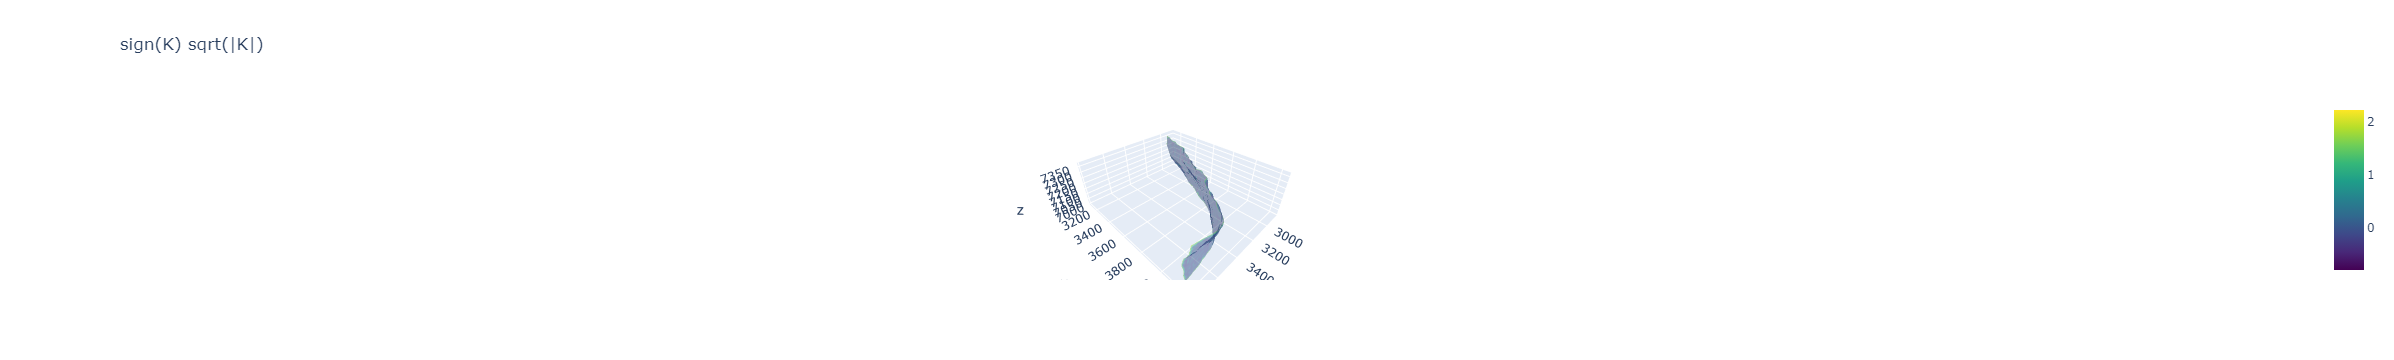

In [29]:
k_normalized = np.sign(k) * np.sqrt(np.abs(k))
show_mesh_without_texture(row.mesh, "sign(K) sqrt(|K|)", colorscale="Viridis", intensity=k_normalized)

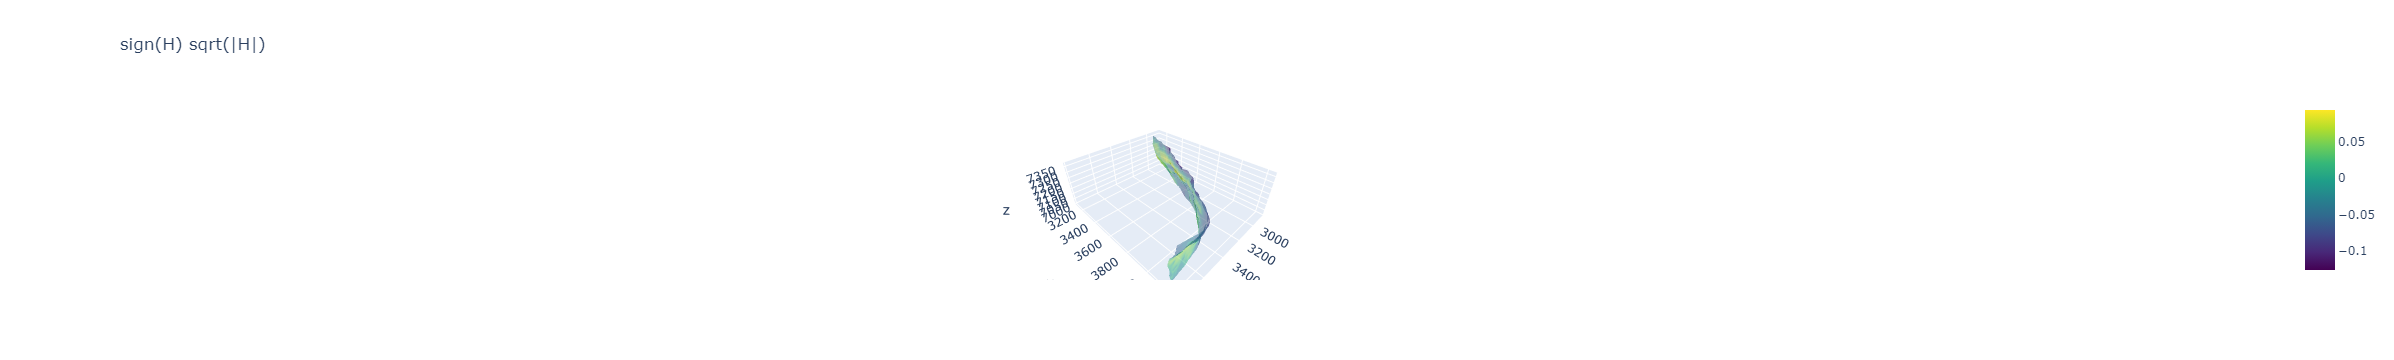

In [30]:
h_normalized = np.sign(h) * np.sqrt(np.abs(h))
show_mesh_without_texture(row.mesh, "sign(H) sqrt(|H|)", colorscale="Viridis", intensity=h_normalized)

From these visualizations, we can see why it's important to only consider the interior of the mesh. That is where we are primarily intetested in.

### Compute the curvature measures

Here, we compute the discrete curvature values for each mesh.

In [31]:
df["h_in"] = df["mesh"].progress_apply(lambda m: get_mean_curvature_internal(m.vertices, m.faces))
df["abs_h_in"] = df["h_in"].apply(np.abs)
df["mean_abs_h_in"] = df["abs_h_in"].apply(np.nanmean)
df["std_abs_h_in"] = df["abs_h_in"].apply(np.nanstd)

  0%|          | 0/235 [00:00<?, ?it/s]

C:\Users\lousc\.virtualenvs\vesuvius-topogeo\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning:

Mean of empty slice

C:\Users\lousc\.virtualenvs\vesuvius-topogeo\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.



In [32]:
df["k_in"] = df["mesh"].progress_apply(lambda m: get_gaussian_curvature_internal(m.vertices, m.faces))
df["abs_k_in"] = df["k_in"].apply(np.abs)
df["mean_abs_k_in"] = df["abs_k_in"].apply(np.nanmean)
df["std_abs_k_in"] = df["abs_k_in"].apply(np.nanstd)

  0%|          | 0/235 [00:00<?, ?it/s]

C:\Users\lousc\.virtualenvs\vesuvius-topogeo\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning:

Mean of empty slice

C:\Users\lousc\.virtualenvs\vesuvius-topogeo\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.



### Intra-group analysis

Here, we'd like to analyze the variation within scrolls and within fragments. That is, we want to compare scroll 1 to scroll 2, scroll segments to themselves, and fragments to themselves.

#### Descriptive statistics

We first look at fragment curvature statistics.

Internal Gaussian curvature:

In [33]:
df.loc[df.volume_type == "fragment"].groupby("fragment_id")["k_in"].apply(describe_array_statistics).unstack()

count      mean       std       min       25%       50%  \
fragment_id                                                              
1            39797.0  0.000142  0.015152 -0.305239 -0.004006 -0.000481   
2            33756.0  0.000082  0.010102 -0.243238 -0.002470 -0.000341   
3            41433.0  0.000127  0.012861 -0.178558 -0.003627 -0.000464   

                  75%       max  
fragment_id                      
1            0.003123  0.399089  
2            0.001939  0.281338  
3            0.002763  0.378514

Internal mean curvature:

In [34]:
df.loc[df.volume_type == "fragment"].groupby("fragment_id")["h_in"].apply(describe_array_statistics).unstack()

count      mean       std       min       25%       50%  \
fragment_id                                                              
1            39797.0  0.000074  0.001271 -0.009042 -0.000678  0.000109   
2            33758.0  0.000020  0.000512 -0.004403 -0.000217  0.000036   
3            41438.0  0.000075  0.001430 -0.009932 -0.000680  0.000091   

                  75%       max  
fragment_id                      
1            0.000847  0.016920  
2            0.000295  0.002768  
3            0.000873  0.009690

Now, let's look at scroll curvature statistics.

Internal Gaussian curvature:

In [35]:
df.loc[df.volume_type == "scroll"].groupby("scroll_id")["k_in"].apply(describe_array_statistics).unstack()

count      mean       std       min       25%       50%  \
scroll_id                                                                
1          2540353.0 -0.000082  0.074616 -5.590093 -0.012466 -0.002090   
2           207397.0 -0.000017  0.100912 -2.575918 -0.020275 -0.003823   

                75%       max  
scroll_id                      
1          0.006248  5.962939  
2          0.011131  2.649116

Internal mean curvature:

In [36]:
df.loc[df.volume_type == "scroll"].groupby("scroll_id")["h_in"].apply(describe_array_statistics).unstack()

count      mean       std       min       25%       50%  \
scroll_id                                                                
1          2540353.0 -0.000209  0.003007 -0.193970 -0.001814 -0.000169   
2           207397.0  0.000088  0.002155 -0.132569 -0.000989  0.000131   

                75%       max  
scroll_id                      
1          0.001434  0.203498  
2          0.001199  0.035473

#### Vertex curvature comparison

We first look at the vertex curvature distributions for the fragments.

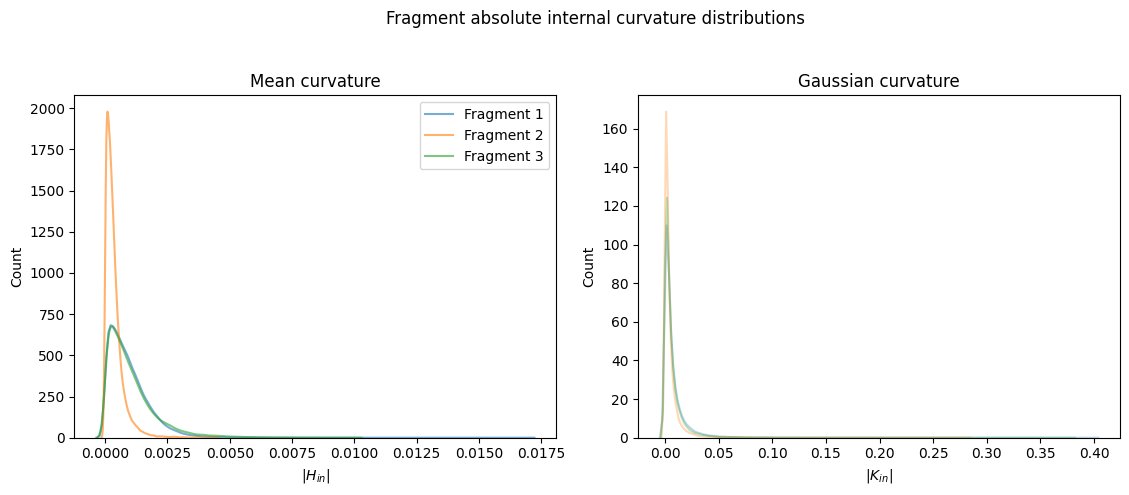

In [37]:
fragment_df = df.loc[df.volume_type == "fragment"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Fragment absolute internal curvature distributions")

# Plotting the first graph (Absolute internal mean curvature distribution)
axes[0].set_title("Mean curvature")
for i, row in fragment_df.iterrows():
    sns.kdeplot(row.abs_h_in, label=f"Fragment {row.fragment_id}", alpha=0.6, ax=axes[0])

axes[0].set_xlabel(r"|$H_{in}$|")
axes[0].set_ylabel("Count")
axes[0].legend()

# Plotting the second graph (Absolute internal Gaussian curvature distribution)
axes[1].set_title("Gaussian curvature")
for i, row in fragment_df.iterrows():
    sns.kdeplot(row.abs_k_in, alpha=0.3, ax=axes[1]) # No label added here

axes[1].set_xlabel(r"|$K_{in}$|")
axes[1].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 0.95, 0.95]) # Adjust layout to fit title
plt.show()

Interestingly, fragment 2 appears to be a bit flatter than the other fragments.

Next, we look at the vertex curvature distributions for the scrolls.

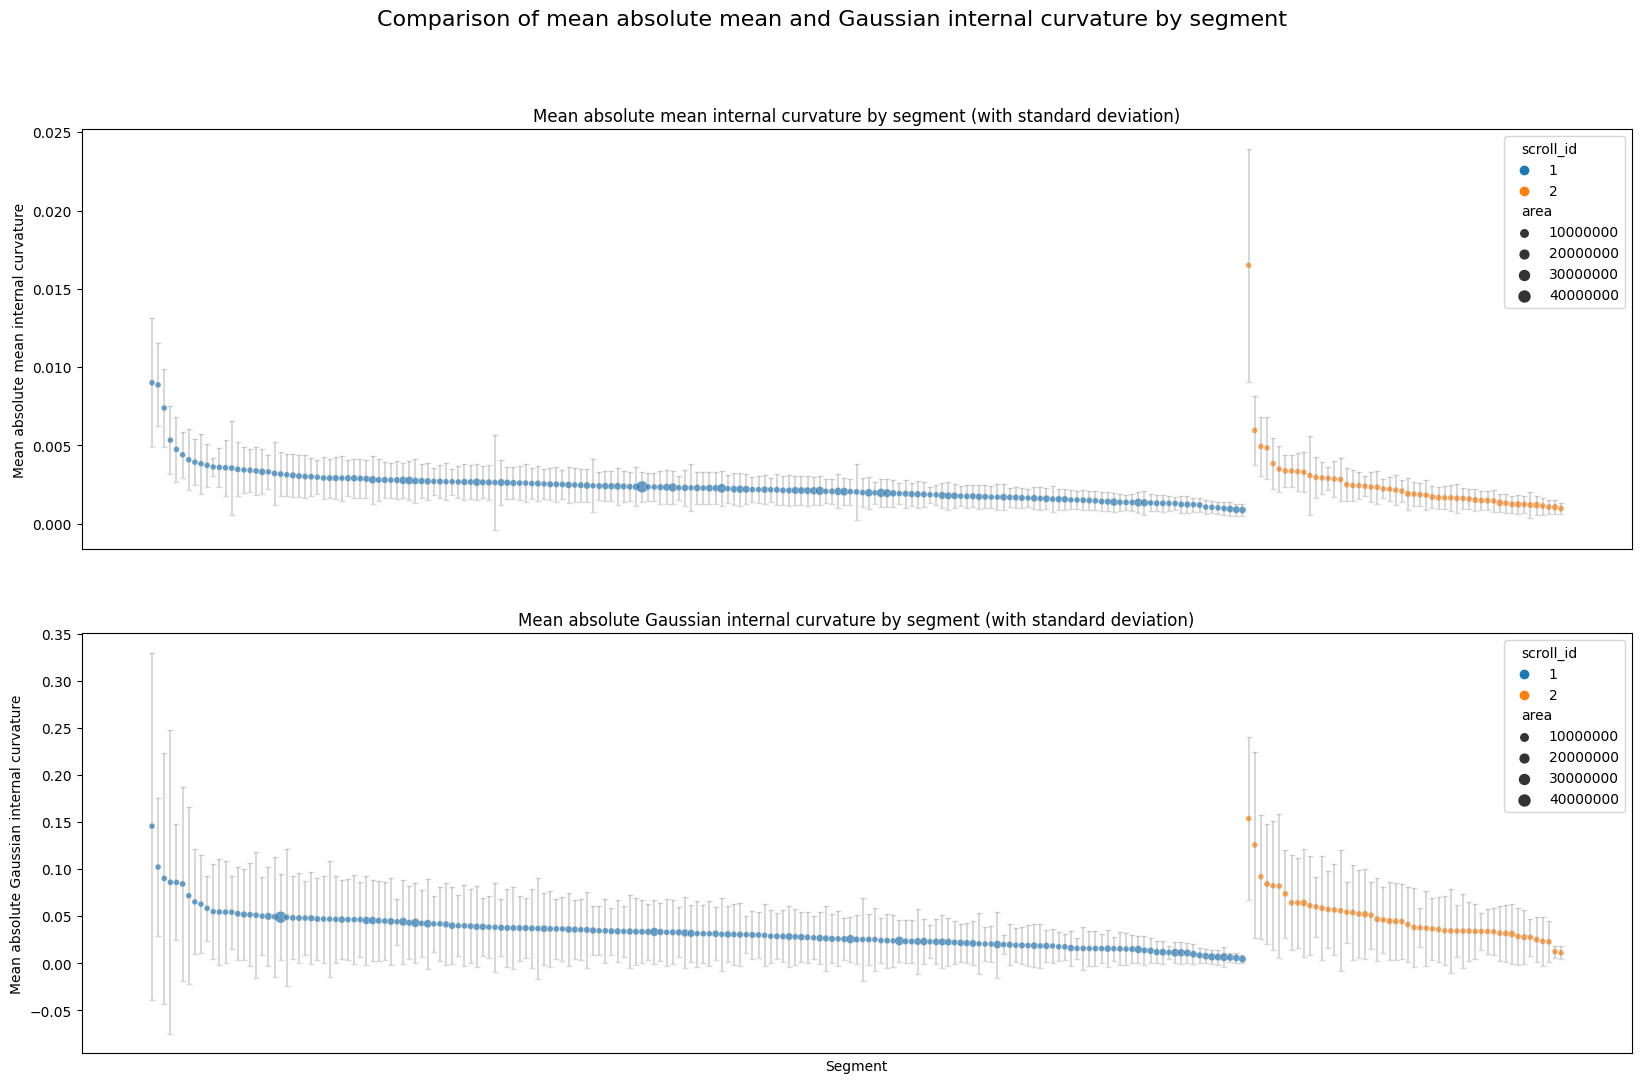

In [38]:
scroll_df = df.loc[df.volume_type == "scroll"]

# Drop any rows with NaN values in the relevant columns
scroll_df_pre = scroll_df.dropna(subset=['mean_abs_h_in', 'std_abs_h_in', 'mean_abs_k_in', 'std_abs_k_in'])

# Sort by 'scroll_id' ascending and 'mean_abs_{k,h}_in' descending
scroll_df_sorted_h = scroll_df_pre.sort_values(by=['scroll_id', 'mean_abs_h_in'], ascending=[True, False]).reset_index(drop=True)
scroll_df_sorted_k = scroll_df_pre.sort_values(by=['scroll_id', 'mean_abs_k_in'], ascending=[True, False]).reset_index(drop=True)

fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

fig.suptitle('Comparison of mean absolute mean and Gaussian internal curvature by segment', fontsize=16)

# Plot for mean absolute internal curvature (h)
sns.scatterplot(data=scroll_df_sorted_h, x=scroll_df_sorted_h.index, y='mean_abs_h_in', 
                hue='scroll_id', size='area', alpha=0.7, ax=axes[0], legend="brief")
for index, row in scroll_df_sorted_h.iterrows():
    axes[0].errorbar(x=index, y=row['mean_abs_h_in'], yerr=row['std_abs_h_in'] * 0.5, fmt='none', capsize=2, alpha=0.3, color='gray')
axes[0].set_title('Mean absolute mean internal curvature by segment (with standard deviation)')
axes[0].set_ylabel('Mean absolute mean internal curvature')

# Plot for Gaussian curvature (k)
sns.scatterplot(data=scroll_df_sorted_k, x=scroll_df_sorted_k.index, y='mean_abs_k_in', 
                hue='scroll_id', size='area', alpha=0.7, ax=axes[1], legend="brief")
for index, row in scroll_df_sorted_k.iterrows():
    axes[1].errorbar(x=index, y=row['mean_abs_k_in'], yerr=row['std_abs_k_in'] * 0.5, fmt='none', capsize=2, alpha=0.3, color='gray')
axes[1].set_title('Mean absolute Gaussian internal curvature by segment (with standard deviation)')
axes[1].set_ylabel('Mean absolute Gaussian internal curvature')
axes[1].set_xlabel('Segment')

plt.xticks([]) # Hide the x-axis tick labels
plt.show()

Besides a couple of outliers, we can see that the average curvature and standard deviation of curvature follow similar distributions for each scroll. We can also see a somewhat monotonic relationship between average curvature and the standard deviation of curvature for each scroll. That tells us that as the average amount of curvature increases, so does the variation.

Next, we look at the **coefficient of variation** (CV), also known as normalized root-mean-square deviation, of the absolute value of both the internal Gaussian and mean curvatures. The coefficient of variation is defined as the ratio of the standard deviation ($\sigma$) to the mean ($\mu$),

$$CV = \frac{\sigma}{\mu}$$

It shows the extent of variability in relation to the mean of the curvatures and helps give a sense of the relative variability within each group, even if the means are drastically different from one another.

The CV for the curvature of a mesh aims to describe the dispersion of the per-mesh curvature such that it is independent of the measurement unit. The higher the CV, the larger the dispersion in the curvature. It's particularly helpful in comparing the scrolls to the fragments because of the respective voxel size differences ($7.91$ microns and $3.24$ microns).

Let's first look at this for the scrolls.

C:\Users\lousc\AppData\Local\Temp\ipykernel_27600\845349229.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lousc\AppData\Local\Temp\ipykernel_27600\845349229.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



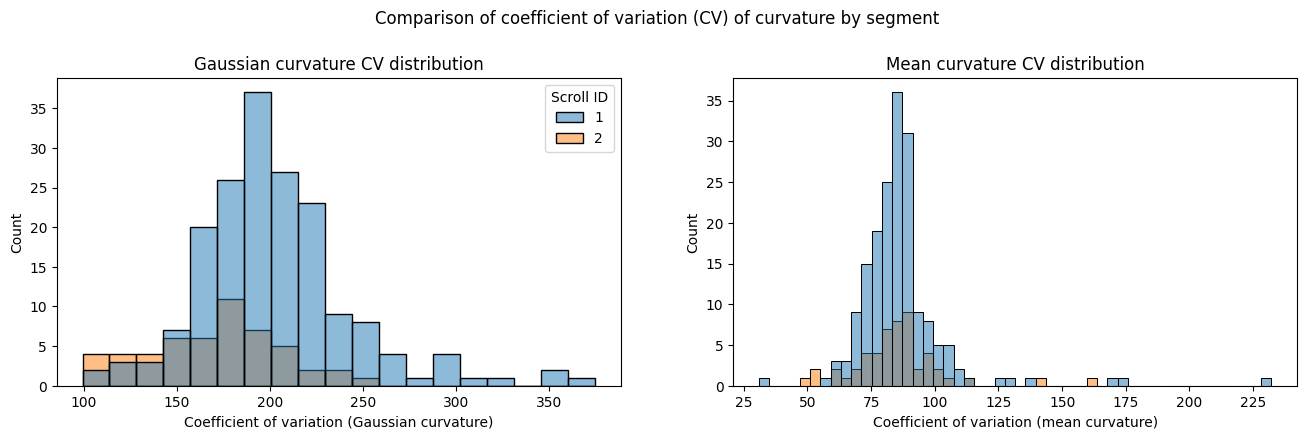

In [39]:
coefficient_of_variation_abs_k_in =  (scroll_df["std_abs_k_in"] / scroll_df["mean_abs_k_in"]) * 100
coefficient_of_variation_abs_h_in = (scroll_df["std_abs_h_in"] / scroll_df["mean_abs_h_in"]) * 100
scroll_df.loc[:, "coefficient_of_variation_abs_k_in"] = coefficient_of_variation_abs_k_in
scroll_df.loc[:, "coefficient_of_variation_abs_h_in"] = coefficient_of_variation_abs_h_in

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

fig.suptitle('Comparison of coefficient of variation (CV) of curvature by segment', y=1.05)

g = sns.histplot(data=scroll_df, x="coefficient_of_variation_abs_k_in", hue="scroll_id", ax=ax1, legend=True)
g.legend_.set_title("Scroll ID")
ax1.set_title("Gaussian curvature CV distribution")
ax1.set_xlabel('Coefficient of variation (Gaussian curvature)')

sns.histplot(data=scroll_df, x="coefficient_of_variation_abs_h_in", hue="scroll_id", ax=ax2, legend=False)
ax2.set_title("Mean curvature CV distribution")
ax2.set_xlabel('Coefficient of variation (mean curvature)')

plt.show()

Now let's look at the CV values for the fragments.

In [40]:
df.loc[:, "coefficient_of_variation_abs_h_in"] = (df["std_abs_h_in"] / df["mean_abs_h_in"]) * 100
df.loc[:, "coefficient_of_variation_abs_k_in"] = (df["std_abs_k_in"] / df["mean_abs_k_in"]) * 100

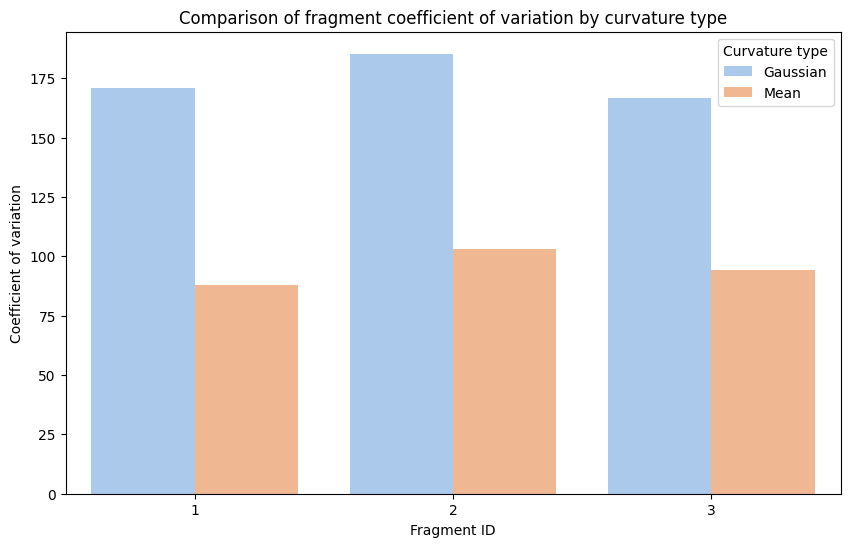

In [41]:
fragment_df = df.loc[df.volume_type == "fragment"]

melted_df = fragment_df.melt(id_vars=['fragment_id'], value_vars=['coefficient_of_variation_abs_k_in', 
                                                                  'coefficient_of_variation_abs_h_in'], 
                             var_name='curvature_type', value_name='coefficient_of_variation')
melted_df['curvature_type'] = melted_df['curvature_type'].replace({
    'coefficient_of_variation_abs_k_in': 'Gaussian',
    'coefficient_of_variation_abs_h_in': 'Mean'
})

plt.figure(figsize=(10, 6))
palette = sns.color_palette("pastel", 2)
sns.barplot(data=melted_df, x='fragment_id', y='coefficient_of_variation', hue='curvature_type', palette=palette)
plt.title('Comparison of fragment coefficient of variation by curvature type')
plt.xlabel('Fragment ID')
plt.ylabel('Coefficient of variation')
plt.legend(title='Curvature type')
plt.show()

### Inter-group analysis

Here we want to analyze the variation between scrolls and fragments.

#### Descriptive statistics

Here, we look at some descriptive curvature statistics between scrolls and fragments.

Internal (signed) Gaussian curvature:

In [42]:
df_k_in_stats = df.groupby("volume_type")["k_in"].apply(describe_array_statistics).unstack()
df_k_in_stats

count      mean       std       min       25%       50%  \
volume_type                                                                
fragment      114986.0  0.000119  0.013001 -0.305239 -0.003344 -0.000415   
scroll       2747750.0 -0.000077  0.076915 -5.590093 -0.012967 -0.002170   

                  75%       max  
volume_type                      
fragment     0.002567  0.399089  
scroll       0.006520  5.962939

Internal (signed) mean curvature:

In [43]:
df_h_in_stats = df.groupby("volume_type")["h_in"].apply(describe_array_statistics).unstack()
df_h_in_stats

count      mean       std       min       25%       50%  \
volume_type                                                                
fragment      114993.0  0.000059  0.001172 -0.009932 -0.000465  0.000066   
scroll       2747750.0 -0.000187  0.002952 -0.193970 -0.001742 -0.000137   

                 75%       max  
volume_type                     
fragment     0.00062  0.016920  
scroll       0.00141  0.203498

To simplify this comparison, we'll look at the average absolute mean internal curvatures.

In [44]:
df_abs_h_in_stats = df.groupby("volume_type")["abs_h_in"].apply(describe_array_statistics).unstack()
df_abs_h_in_stats

count      mean       std           min       25%       50%  \
volume_type                                                                    
fragment      114993.0  0.000811  0.000848  0.000000e+00  0.000232  0.000547   
scroll       2747750.0  0.002121  0.002061  1.041925e-09  0.000720  0.001576   

                  75%       max  
volume_type                      
fragment     0.001125  0.016920  
scroll       0.002897  0.203498

We can compare the ratios of the means as an approximation to how much more curved the scrolls are compared to the fragments.

In [45]:
# Extract the mean values
mean_scroll = df_abs_h_in_stats.loc['scroll', 'mean']
mean_fragment = df_abs_h_in_stats.loc['fragment', 'mean']

print(f"The scrolls are around {mean_scroll / mean_fragment:0.2f} times more curved than the fragments on average.")

The scrolls are around 2.62 times more curved than the fragments on average.


Let's compare each scroll individually to all fragments.

In [46]:
df_abs_h_in_stats_by_scroll = df.groupby(["volume_type", "scroll_id"])["abs_h_in"].apply(describe_array_statistics).unstack()
df_abs_h_in_stats_by_scroll

count      mean       std           min       25%  \
volume_type scroll_id                                                          
scroll      1          2540353.0  0.002172  0.002090  1.041925e-09  0.000744   
            2           207397.0  0.001503  0.001546  1.964883e-08  0.000511   

                            50%       75%       max  
volume_type scroll_id                                
scroll      1          0.001627  0.002971  0.203498  
            2          0.001102  0.002005  0.132569

In [47]:
# Extract the mean values
mean_scroll_1 = df_abs_h_in_stats_by_scroll.loc[('scroll', '1'), 'mean']
mean_scroll_2 = df_abs_h_in_stats_by_scroll.loc[('scroll', '2'), 'mean']

print(f"Scroll 1 is around {mean_scroll_1 / mean_fragment:0.2f} times more curved than the fragments on average.")
print(f"Scroll 2 is around {mean_scroll_2 / mean_fragment:0.2f} times more curved than the fragments on average.")

Scroll 1 is around 2.68 times more curved than the fragments on average.
Scroll 2 is around 1.85 times more curved than the fragments on average.


Let's compare each fragment individually to all scrolls.

In [48]:
df_abs_h_in_stats_by_fragment = df.groupby(["volume_type", "fragment_id"])["abs_h_in"].apply(describe_array_statistics).unstack()
df_abs_h_in_stats_by_fragment

count      mean       std           min       25%  \
volume_type fragment_id                                                        
fragment    1            39797.0  0.000957  0.000841  2.766000e-08  0.000356   
            2            33758.0  0.000357  0.000368  0.000000e+00  0.000120   
            3            41438.0  0.001042  0.000982  0.000000e+00  0.000359   

                              50%       75%       max  
volume_type fragment_id                                
fragment    1            0.000768  0.001333  0.016920  
            2            0.000258  0.000464  0.004403  
            3            0.000779  0.001403  0.009932

In [49]:
# Extract the mean values
mean_fragment_1 = df_abs_h_in_stats_by_fragment.loc[('fragment', '1'), 'mean']
mean_fragment_2 = df_abs_h_in_stats_by_fragment.loc[('fragment', '2'), 'mean']
mean_fragment_3 = df_abs_h_in_stats_by_fragment.loc[('fragment', '3'), 'mean']

print(f"Fragment 1 is around {mean_scroll / mean_fragment_1:0.2f} times smoother than the scrolls on average.")
print(f"Fragment 2 is around {mean_scroll / mean_fragment_2:0.2f} times smoother than the scrolls on average.")
print(f"Fragment 3 is around {mean_scroll / mean_fragment_3:0.2f} times smoother than the scrolls on average.")

Fragment 1 is around 2.22 times smoother than the scrolls on average.
Fragment 2 is around 5.95 times smoother than the scrolls on average.
Fragment 3 is around 2.04 times smoother than the scrolls on average.


Let's compare each fragment with each scroll individually.

In [50]:
print(f"Scroll 1 is around {mean_scroll_1 / mean_fragment_1:0.2f} times more curved than fragment 1 on average.")
print(f"Scroll 1 is around {mean_scroll_1 / mean_fragment_2:0.2f} times more curved than fragment 2 on average.")
print(f"Scroll 1 is around {mean_scroll_1 / mean_fragment_3:0.2f} times more curved than fragment 3 on average.")
print("-" * 65)
print(f"Scroll 2 is around {mean_scroll_2 / mean_fragment_1:0.2f} times more curved than fragment 1 on average.")
print(f"Scroll 2 is around {mean_scroll_2 / mean_fragment_2:0.2f} times more curved than fragment 2 on average.")
print(f"Scroll 2 is around {mean_scroll_2 / mean_fragment_3:0.2f} times more curved than fragment 3 on average.")

Scroll 1 is around 2.27 times more curved than fragment 1 on average.
Scroll 1 is around 6.09 times more curved than fragment 2 on average.
Scroll 1 is around 2.08 times more curved than fragment 3 on average.
-----------------------------------------------------------------
Scroll 2 is around 1.57 times more curved than fragment 1 on average.
Scroll 2 is around 4.21 times more curved than fragment 2 on average.
Scroll 2 is around 1.44 times more curved than fragment 3 on average.


So scroll 2 and fragment 1 are the closest in terms of cross-domain curvature whereas scroll 1 and fragment 2 are the most dissimilar.

Let's investigate the coefficient of variation for each curvature type on scrolls vs fragments.

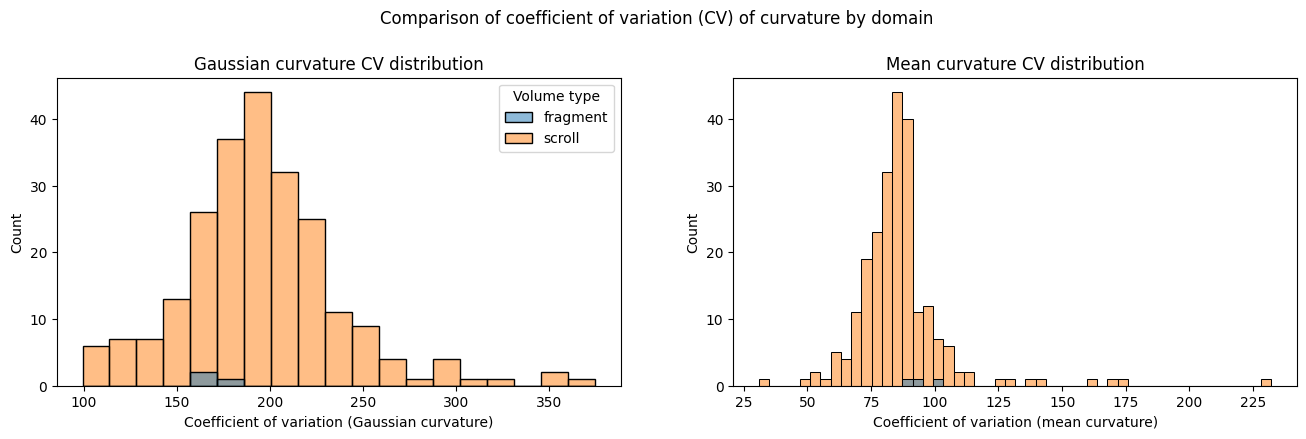

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('Comparison of coefficient of variation (CV) of curvature by domain', y=1.05)

g = sns.histplot(data=df, x="coefficient_of_variation_abs_k_in", hue="volume_type", ax=ax1, legend=True)
g.legend_.set_title("Volume type")
ax1.set_title("Gaussian curvature CV distribution")
ax1.set_xlabel('Coefficient of variation (Gaussian curvature)')

sns.histplot(data=df, x="coefficient_of_variation_abs_h_in", hue="volume_type", ax=ax2, legend=False)
ax2.set_title("Mean curvature CV distribution")
ax2.set_xlabel('Coefficient of variation (mean curvature)')

plt.show()

We can see that for both fragments and scrolls the deviation of the discrete curvatures relative to the per-mesh average level of curvature is similar.

#### Vertex curvature comparison

Now we compare the scroll curvature and fragment curvature distributions

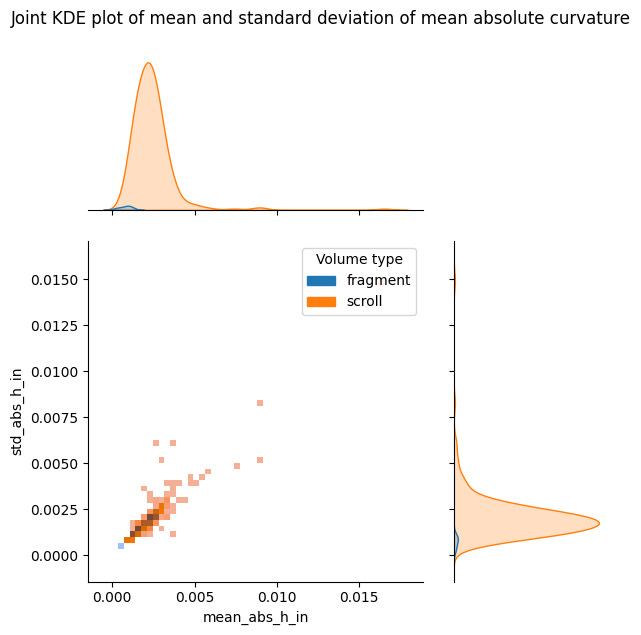

In [52]:
g = sns.JointGrid(data=df, x="mean_abs_h_in", y="std_abs_h_in", hue="volume_type", ratio=2)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.kdeplot, fill=True)
g.ax_joint.legend_.set_title('Volume type')

plt.suptitle('Joint KDE plot of mean and standard deviation of mean absolute curvature', fontsize=12, y=1.05)
plt.xlabel('Average absolute mean curvature', fontsize=10)
plt.ylabel('Standard deviation of absolute mean curvature', fontsize=10)
plt.show()

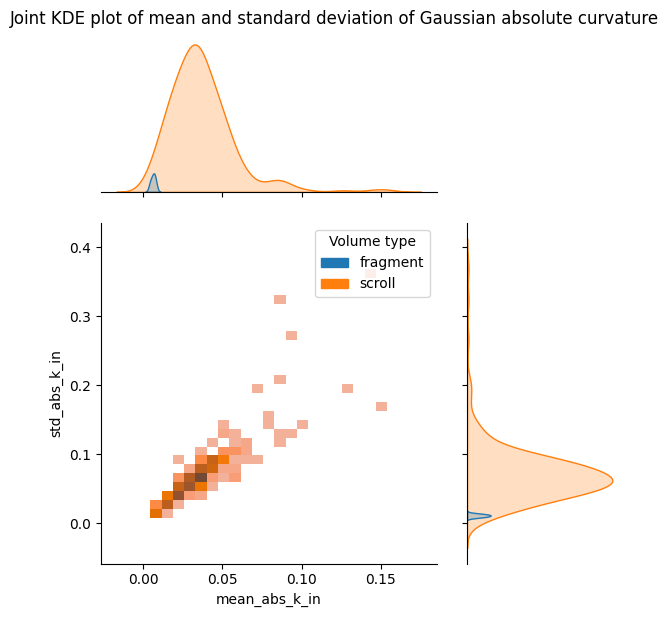

In [53]:
g = sns.JointGrid(data=df, x="mean_abs_k_in", y="std_abs_k_in", hue="volume_type", ratio=2)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.kdeplot, fill=True)
g.ax_joint.legend_.set_title('Volume type')

plt.suptitle('Joint KDE plot of mean and standard deviation of Gaussian absolute curvature', fontsize=12, y=1.02)
plt.xlabel('Average absolute Gaussian curvature', fontsize=10)
plt.ylabel('Standard deviation of absolute Gaussian curvature', fontsize=10)
plt.show()

We can see that the fragments are indeed less curved on average and exhibit less variation in curvature than the scroll segments.

#### Statistical comparison

Last but not least, we want to statistically compare the two domains to confirm our hypothesis that they are significantly different. We can do that using three statistical tests:

1. *Mann-Whitney U Test*
   - This roughly tests that the medians are different
1. *Levene's test*
   - This roughly tests that the variances are different
1. *Kolmogorov–Smirnov test*
   - This roughly tests that the distributions are different

In [54]:
curvatures_h_in_scrolls = df.loc[df.volume_type == "scroll"].explode("h_in")["h_in"].dropna().values.astype(float)
curvatures_h_in_fragments = df.loc[df.volume_type == "fragment"].explode("h_in")["h_in"].dropna().values.astype(float)
curvatures_h_in_scrolls.shape, curvatures_h_in_fragments.shape

((2747750,), (114993,))

In [55]:
curvatures_k_in_scrolls = df.loc[df.volume_type == "scroll"].explode("k_in")["k_in"].dropna().values.astype(float)
curvatures_k_in_fragments = df.loc[df.volume_type == "fragment"].explode("k_in")["k_in"].dropna().values.astype(float)
curvatures_k_in_scrolls.shape, curvatures_k_in_fragments.shape

((2747750,), (114986,))

Mann-Whitney U Test

In [56]:
# mean curvature
u_statistic, p_value = mannwhitneyu(curvatures_h_in_scrolls, curvatures_h_in_fragments, nan_policy='raise')

if p_value < 0.05:
    print("There is a significant difference between the two groups of mean curvature.")
else:
    print("There is no significant difference between the two groups of mean curvature.")

print(f"p-value: {p_value}")

There is a significant difference between the two groups of mean curvature.
p-value: 0.0


In [57]:
# Gaussian curvature
u_statistic, p_value = mannwhitneyu(curvatures_k_in_scrolls, curvatures_k_in_fragments, nan_policy='raise')

if p_value < 0.05:
    print("There is a significant difference between the two groups of Gaussian curvature.")
else:
    print("There is no significant difference between the two groups of Gaussian curvature.")

print(f"p-value: {p_value}")

There is a significant difference between the two groups of Gaussian curvature.
p-value: 0.0


Levene's test

In [58]:
# Using the median for centering (Brown-Forsythe version)
levene_statistic, p_value = levene(curvatures_h_in_scrolls, curvatures_h_in_fragments, center='median')

if p_value < 0.05:
    print("There is a significant difference in variances between the two groups of mean curvature.")
else:
    print("There is no significant difference in variances between the two groups of mean curvature.")

print(f"p-value: {p_value}")

There is a significant difference in variances between the two groups of mean curvature.
p-value: 0.0


In [59]:
# Using the median for centering (Brown-Forsythe version)
levene_statistic, p_value = levene(curvatures_k_in_scrolls, curvatures_k_in_fragments, center='median')

if p_value < 0.05:
    print("There is a significant difference in variances between the two groups of Gaussian curvature.")
else:
    print("There is no significant difference in variances between the two groups of Gaussian curvature.")

print(f"p-value: {p_value}")

There is a significant difference in variances between the two groups of Gaussian curvature.
p-value: 0.0


Kolmogorov–Smirnov test

In [60]:
ks_statistic, p_value = ks_2samp(curvatures_h_in_scrolls, curvatures_h_in_fragments)

if p_value < 0.05:
    print("There is a significant difference between the distributions of the two groups of mean curvature.")
else:
    print("There is no significant difference between the distributions of the two groups of mean curvature.")

print(f"p-value: {p_value}")

There is a significant difference between the distributions of the two groups of mean curvature.
p-value: 0.0


In [61]:
ks_statistic, p_value = ks_2samp(curvatures_k_in_scrolls, curvatures_k_in_fragments)

if p_value < 0.05:
    print("There is a significant difference between the distributions of the two groups of Gaussian curvature.")
else:
    print("There is no significant difference between the distributions of the two groups of Gaussian curvature.")


print(f"p-value: {p_value}")

There is a significant difference between the distributions of the two groups of Gaussian curvature.
p-value: 0.0


From these tests, we can conclude that median curvatures are significantly different, the variance of curvatures are significantly different and the curvatures are likely generated from different distributions. We confirmed statistically that the gap between scrolls and fragments, with respect to their mesh curvatures, is significant. Further work is needed to understand precisely *why* the p-values are exactly zero.

## Conclusion

In this analysis, we characterized the geometric and topological differences within fragments, within scrolls, and between scrolls and fragments. Our primary focus was the distribution of discrete local curvature for each mesh.

It is well known that the scrolls and fragments differ in spatial resolution, with the scrolls being roughly twice as coarse. However, the results indicate that the domain gap isn't limited to the differing voxel sizes. As suspected, the domains of scrolls and fragments indeed differ significantly with respect to their geometry and topology.

Given these major distributional differences, it remains an open problem how to best bridge the scroll-to-fragment domain gap. Further work is needed, particularly in assessing mesh quality and its relationship to textural features with respect to the ink signal. Handling this domain shift would likely enhance the performance of ink detection models and provide a clearer interpretation of ink signals.